In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from data_preprocessing import get_dataloaders
import matplotlib.pyplot as plt

训练集大小: 5216 样本
验证集大小: 16 样本
Epoch 1/50
训练损失: 0.3910, 训练准确率: 0.8183
验证损失: 0.6732, 验证准确率: 0.6250
保存最佳模型
------------------------------
Epoch 2/50
训练损失: 0.2383, 训练准确率: 0.8992
验证损失: 0.6129, 验证准确率: 0.8125
保存最佳模型
------------------------------
Epoch 3/50
训练损失: 0.2218, 训练准确率: 0.9064
验证损失: 0.9295, 验证准确率: 0.6250
------------------------------
Epoch 4/50
训练损失: 0.2147, 训练准确率: 0.9120
验证损失: 1.0408, 验证准确率: 0.6250
------------------------------
Epoch 5/50
训练损失: 0.2005, 训练准确率: 0.9162
验证损失: 0.5650, 验证准确率: 0.6250
保存最佳模型
------------------------------
Epoch 6/50
训练损失: 0.1912, 训练准确率: 0.9224
验证损失: 0.6167, 验证准确率: 0.6250
------------------------------
Epoch 7/50
训练损失: 0.1761, 训练准确率: 0.9277
验证损失: 0.6064, 验证准确率: 0.6250
------------------------------
Epoch 8/50
训练损失: 0.1804, 训练准确率: 0.9293
验证损失: 0.5202, 验证准确率: 0.6875
保存最佳模型
------------------------------
Epoch 9/50
训练损失: 0.1759, 训练准确率: 0.9260
验证损失: 0.6304, 验证准确率: 0.5625
------------------------------
Epoch 10/50
训练损失: 0.1827, 训练准确率: 0.9275
验证损失: 0.8818, 验证准确率: 0

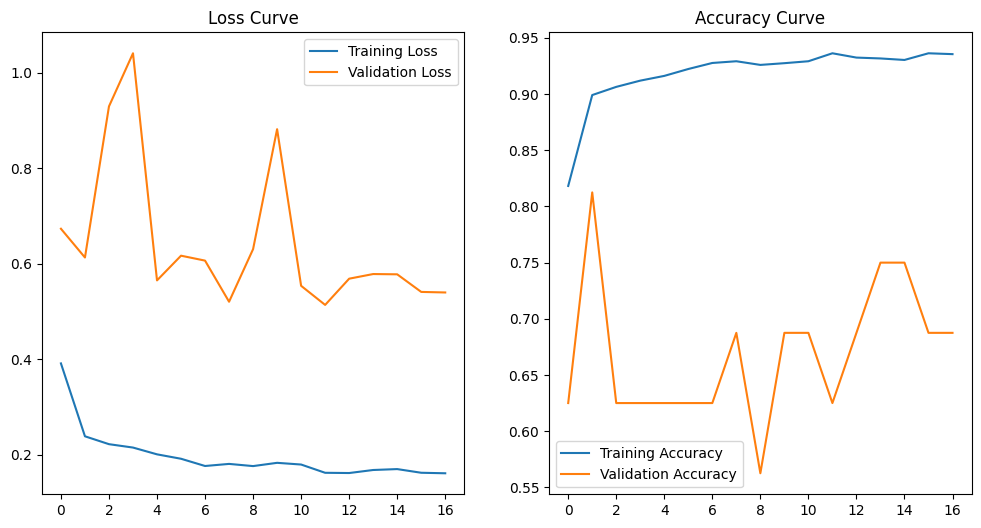

模型训练完毕，并已保存最佳模型。


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 可选模型名称：'resnet50'、'mobilenet_v3'（此处使用 mobilenet_v3_large）、'efficientnet_b0'
model_name = 'mobilenet_v3'  # 修改此变量选择模型

def create_model(model_name=model_name):
    if model_name.lower() == 'resnet50':
        model = models.resnet50(pretrained=True)
        # 冻结预训练层参数
        for param in model.parameters():
            param.requires_grad = False
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )
    elif model_name.lower() == 'mobilenet_v3':
        # 使用 MobileNetV3_large
        model = models.mobilenet_v3_large(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        # 取出 backbone 后最后一层特征的维度（mobilenet_v3_large 的 classifier[0] 输入为 960）
        in_features = model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )
    elif model_name.lower() == 'efficientnet_b0':
        # 使用 EfficientNet-B0（需要 torchvision 版本支持 efficientnet_b0）
        model = models.efficientnet_b0(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )
    else:
        raise ValueError("model_name 仅支持 'resnet50'、'mobilenet_v3' 或 'efficientnet_b0'")
    
    return model.to(device)

def train_model(num_epochs=50, batch_size=32, patience=5):
    train_loader, val_loader = get_dataloaders(batch_size=batch_size)
    model = create_model(model_name)
    
    # 使用 BCEWithLogitsLoss（内部集成 sigmoid）
    criterion = nn.BCEWithLogitsLoss()
    # 只优化新定义的分类器部分
    if model_name.lower() == 'resnet50':
        optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)
    elif model_name.lower() == 'mobilenet_v3':
        optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
    elif model_name.lower() == 'efficientnet_b0':
        optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, min_lr=1e-6)
    
    best_val_loss = float('inf')
    best_model_wts = None
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        # 训练阶段
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            # labels 转换为 float 并扩展维度 [batch, 1]
            labels = labels.float().unsqueeze(1).to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5)
            running_corrects += torch.sum(preds == labels.byte())
            total += inputs.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        
        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                preds = (torch.sigmoid(outputs) >= 0.5)
                val_running_corrects += torch.sum(preds == labels.byte())
                val_total += inputs.size(0)
        
        val_loss = val_running_loss / val_total
        val_acc = val_running_corrects.double() / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        
        print(f"训练损失: {epoch_loss:.4f}, 训练准确率: {epoch_acc:.4f}")
        print(f"验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # 早停逻辑
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
            # 保存最佳模型
            save_path = r'C:\Users\wzf20\Desktop\chest_xray_pneumonia\models\model.pth'
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model.state_dict(), save_path)
            print("保存最佳模型")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("验证损失没有改善，提前停止训练")
                break
    
        print("-" * 30)
    
    # 加载最佳模型权重
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    # 绘制训练与验证损失和准确率曲线
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    
    plt.show()
    print("模型训练完毕，并已保存最佳模型。")

if __name__ == '__main__':
    train_model()